In [4]:
# （必須）モジュールのインポート
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 表示設定
np.set_printoptions(suppress=True, precision=3)
pd.set_option('display.precision', 3)    # 小数点以下の表示桁
pd.set_option('display.max_rows', 50)   # 表示する行数の上限
pd.set_option('display.max_columns', 15)  # 表示する列数の上限
%precision 3

'%.3f'


# トラッキングデータの解析

## トラッキングデータ

### Pettersenデータセット

Pettersenデータセットはサッカーのトラッキングデータをまとめたデータセットである．
試合数は3試合と少ないが，2024年時点で一般公開されている数少ないサッカートラッキングデータである．

### データセットの内容

本データセットに含まれるトラッキングデータはノルウェーのAlfheimスタジアムにおいて取得されている．
対象となる試合はAlfheimスタジアムを本拠地とするTromsø ILの3試合である．
データセットには試合映像とGPSデバイスによって取得された位置座標のデータ（トラッキングデータ）が含まれている．
ただし，トラッキングデータの取得対象はTromsø ILの選手のみである．
また，選手のプライバシー保護のため，トラッキングデータから選手の個人情報は除去されている．

トラッキングデータの位置座標は以下のような座標系において，1秒間に20フレーム（20fps）の解像度で取得されている．

- 原点：フィールドの左下
- $x$軸：長軸方向（$0 \le x \le 105$）
- $y$軸：短軸方向（$0 \le x \le 68$）
- 単位はm

## データの前処理

ここでは，Tromsø IL vs Strømsgodsetのトラッキングデータを解析対象とする．
まずはトラッキングデータのcsvファイルを以下からダウンロードし，カレントディレクトリに移動しておく：

- 前半のデータ：[2013-11-03_tromso_stromsgodset_first.csv](https://datasets.simula.no/downloads/alfheim/2013-11-03/zxy/2013-11-03_tromso_stromsgodset_first.csv)
- 後半のデータ：[2013-11-03_tromso_stromsgodset_second.csv](https://datasets.simula.no/downloads/alfheim/2013-11-03/zxy/2013-11-03_tromso_stromsgodset_second.csv)

なお，以下では前半の解析例だけを示す．

### データの加工・整形

**データの読み込み**

ダウンロードしたcsvファイルを`df`という名前でDataFrameに読み込む．
その際に列ラベル（`columns`）を指定しておく．

In [2]:
df = pd.read_csv('./2013-11-03_tromso_stromsgodset_first.csv',\
                 header=None, encoding='utf-8',\
                 names=['time','id','x','y','heading','direction','energy','speed','total_distance'])
df.head(2)

,time,id,x,y,heading,direction,energy,speed,total_distance
0,2013-11-03 18:01:09,2,26.573,29.436,0.800,0.824,150.662,0.968,255.584
1,2013-11-03 18:01:09,5,35.550,30.268,1.158,-0.175,364.309,0.624,297.861


**時刻・選手ID・位置座標の抽出**

読み込んだデータには向き（'heading', 'direction'）や速さ（'speed'）などの列も含まれているが，以下では時刻（'time'），選手ID（'id'），位置座標（'x', 'y'）の情報だけを用いるので，これらを抽出する．

In [3]:
df = df[['time', 'id', 'x', 'y']]
df.head(2)

,time,id,x,y
0,2013-11-03 18:01:09,2,26.573,29.436
1,2013-11-03 18:01:09,5,35.550,30.268


**DataFrameの並び替え**

次に，`sort_values`メソッドを用いて，'time'列，'id'列をキーにして`df`をソートする．これにより`df`の行方向の並びが時間順となり，同一時刻の場合は選手ID順となる．

In [4]:
# time列, id列でソート
df = df.sort_values(['time', 'id']).reset_index(drop=1)
df.head(2)

,time,id,x,y
0,2013-11-03 18:01:09,1,53.138,44.062
1,2013-11-03 18:01:09,2,26.573,29.436


**日時の変換**

'time'列には試合が行われた年月日および時刻が文字列として保存されている．
このうち，前半の年月日の情報は不要なので，`str.split`メソッドを用いて年月日と時刻を切り離す．

In [5]:
temp = df['time'].str.split(' ', expand=True)
temp.head(2)

,0,1
0,2013-11-03,18:01:09
1,2013-11-03,18:01:09


時刻の情報は`18:01:09`という形式の文字列である．
これを以下の手順に従い試合開始からの経過時間に変換する：
- 時・分・秒を`str.split`メソッドによって切り離す
- 分と秒の情報だけを取り出し，単位を秒に変換する
- `df`の第0行からの経過時間に変換し，`df`の'time'列に追加する

In [6]:
# 経過時間（秒）に変換
times = temp[1].str.split(':', expand=True).astype(float)
sec = times[1]*60 + times[2]
df['time'] = sec - sec.iloc[0]

df.head(2)

,time,id,x,y
0,0.0,1,53.138,44.062
1,0.0,2,26.573,29.436


**選手別の座標に変換**

各選手の $x$ 座標と $y$ 座標を格納した以下のようなデータフレーム（`df_x`，`df_y`）を作成する：

- 行ラベル（`index`）：フレーム番号
    - 1行=1フレーム=0.05秒
- 列ラベル（`columns`）：選手ID
- $(i, j)$ 成分：ある時刻における特定の選手の $x, y$ 座標

In [7]:
U = df['id'].unique()  # 選手ID
T = np.arange(0, df['time'].max()+0.05, 0.05)  # 0.05秒刻みの経過時間
df_x = pd.DataFrame({'t': T})  # x座標
df_y = pd.DataFrame({'t': T})  # y座標

for u in U:
    df_u = df.loc[df['id']==u]  # 選手uだけ抽出
    df_u.index = (df_u['time']/0.05).round().astype(int)  # インデックスをフレーム番号に

    df_x[u], df_y[u] = np.nan, np.nan
    df_x.loc[df_u.index, u] = df_u['x']
    df_y.loc[df_u.index, u] = df_u['y']

df_x, df_y = df_x[U], df_y[U]  # 't'列を除去

In [8]:
df_x.head()

,1,2,5,7,8,9,10,12,13,14,15,6,11,3
0,53.138,26.573,35.550,41.586,28.507,32.254,45.247,74.59,21.029,28.530,50.084,NaN,NaN,NaN
1,53.138,26.609,35.545,41.572,28.537,32.254,45.247,74.59,21.070,28.528,50.105,NaN,NaN,NaN
2,53.138,26.645,35.539,41.557,28.568,32.254,45.247,74.59,21.114,28.525,50.134,NaN,NaN,NaN
3,53.138,26.682,35.534,41.543,28.596,32.254,45.247,74.59,21.161,28.521,50.169,NaN,NaN,NaN
4,53.138,26.719,35.528,41.529,28.624,32.254,45.247,74.59,21.209,28.516,50.210,NaN,NaN,NaN


In [9]:
df_y.head()

,1,2,5,7,8,9,10,12,13,14,15,6,11,3
0,44.062,29.436,30.268,38.675,39.612,12.724,14.462,71.048,17.624,17.597,25.779,NaN,NaN,NaN
1,44.062,29.467,30.299,38.663,39.568,12.724,14.462,71.048,17.623,17.561,25.722,NaN,NaN,NaN
2,44.062,29.495,30.331,38.651,39.525,12.724,14.462,71.048,17.616,17.532,25.665,NaN,NaN,NaN
3,44.062,29.520,30.364,38.640,39.486,12.724,14.462,71.048,17.603,17.510,25.607,NaN,NaN,NaN
4,44.062,29.541,30.397,38.629,39.449,12.724,14.462,71.048,17.584,17.495,25.549,NaN,NaN,NaN


### 不要な選手の除去

`df_x`，`df_y`には以下の選手の座標が含まれている：

In [10]:
df_x.columns

Index([1, 2, 5, 7, 8, 9, 10, 12, 13, 14, 15, 6, 11, 3], dtype='object')

この中には，実際に試合に出場した選手の他に審判などの位置座標も含まれている．
これら不要なデータを特定するため，選手IDごとに位置座標をプロットしてみる．

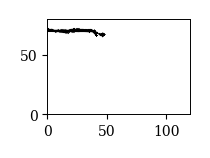

In [11]:
u = 6
fig, ax = plt.subplots(figsize=(2, 2))
ax.plot(df_x[u], df_y[u], '.', ms=0.1)
ax.set_xlim(0, 120); ax.set_ylim(0, 80)
ax.set_aspect('equal')

位置座標をプロットした結果を踏まえると，以下の10人が試合に出場した選手と考えられる：
```
1, 2, 5, 7, 8, 9, 10, 13, 14, 15
```
`df_x`，`df_y`からこれらの選手のデータだけ抽出する．

In [12]:
df_x2 = df_x[[1, 2, 5, 7, 8, 9, 10, 13, 14, 15]]
df_y2 = df_y[[1, 2, 5, 7, 8, 9, 10, 13, 14, 15]]

In [13]:
df_x2.head(2)

,1,2,5,7,8,9,10,13,14,15
0,53.138,26.573,35.550,41.586,28.507,32.254,45.247,21.029,28.530,50.084
1,53.138,26.609,35.545,41.572,28.537,32.254,45.247,21.070,28.528,50.105


In [14]:
df_y2.head(2)

,1,2,5,7,8,9,10,13,14,15
0,44.062,29.436,30.268,38.675,39.612,12.724,14.462,17.624,17.597,25.779
1,44.062,29.467,30.299,38.663,39.568,12.724,14.462,17.623,17.561,25.722


### データの保存

In [15]:
df_x2.to_csv('./x_1st.csv', header=True, index=True, encoding='utf-8')
df_y2.to_csv('./y_1st.csv', header=True, index=True, encoding='utf-8')

### 発展問題

- トラッキングデータの前処理を行う関数を作成せよ
- この関数を用いて後半のデータや他の試合のデータの前処理を行え

## トラッキングデータ解析の基本

### データの読み込み

改めて，作成したデータを`X`，`Y`というDataFrameに読み込む．

In [19]:
X = pd.read_csv('./x_1st.csv', encoding='utf-8', index_col=0)
Y = pd.read_csv('./y_1st.csv', encoding='utf-8', index_col=0)

### データの扱い方

**データの構造**

データフレーム`X`，`Y`は以下のような構造になっている：
- 行ラベル（`index`）：フレーム番号
    - 1行=1フレーム=0.05秒
- 列ラベル（`columns`）：選手ID
- $(i, j)$ 成分：ある時刻における特定の選手の$x, y$座標

In [17]:
X.head(2)

,1,2,5,7,8,9,10,13,14,15
0,53.138,26.573,35.550,41.586,28.507,32.254,45.247,21.029,28.530,50.084
1,53.138,26.609,35.545,41.572,28.537,32.254,45.247,21.070,28.528,50.105


In [20]:
Y.head(2)

,1,2,5,7,8,9,10,13,14,15
0,44.062,29.436,30.268,38.675,39.612,12.724,14.462,17.624,17.597,25.779
1,44.062,29.467,30.299,38.663,39.568,12.724,14.462,17.623,17.561,25.722


**特定の時間帯の抽出**

`X`，`Y`の行ラベル（`index`）はフレーム番号に等しい．
1フレーム=0.05秒なので，試合開始 $t$ 秒後の座標は$20\times t$ 行目を参照すれば良い．
よって，`X`，`Y`から`loc`属性を用いて条件付き抽出すれば，特定の時刻のデータだけ抜き出せる．
例えば，10秒〜20秒の時間帯だけ抽出するには，行ラベル（`index`）が200から400までの行を条件付き抽出すればよい．

In [21]:
X.loc[200:400]

,1,2,5,7,8,9,10,13,14,15
200,54.117,24.796,37.753,41.883,27.185,32.940,43.509,21.114,27.968,53.166
201,54.274,24.816,37.778,41.877,27.184,32.941,43.544,21.073,27.968,53.314
202,54.434,24.837,37.806,41.872,27.185,32.942,43.581,21.042,27.942,53.467
203,54.598,24.858,37.835,NaN,27.187,32.942,43.621,21.021,27.790,53.626
204,54.765,24.879,37.866,41.866,27.190,32.941,43.661,21.009,27.794,53.791
...,...,...,...,...,...,...,...,...,...,...
396,52.730,13.496,27.312,26.922,12.059,19.891,33.062,14.049,22.357,55.207
397,52.852,13.704,27.404,27.127,12.069,20.135,33.228,14.204,22.507,55.274
398,52.978,13.916,27.493,27.336,12.084,20.381,33.396,14.359,22.656,55.339
399,53.105,14.133,27.580,27.549,12.103,20.629,33.565,14.513,22.804,55.402


フレーム番号を秒単位に直すのが面倒な場合は，以下のように`index`を秒単位に変換した`T`というSeriesを作っておき，これを用いて条件付き抽出すればよい．

In [22]:
T = X.index * 0.05
X.loc[(T >= 10) & (T <= 20)]

,1,2,5,7,8,9,10,13,14,15
200,54.117,24.796,37.753,41.883,27.185,32.940,43.509,21.114,27.968,53.166
201,54.274,24.816,37.778,41.877,27.184,32.941,43.544,21.073,27.968,53.314
202,54.434,24.837,37.806,41.872,27.185,32.942,43.581,21.042,27.942,53.467
203,54.598,24.858,37.835,NaN,27.187,32.942,43.621,21.021,27.790,53.626
204,54.765,24.879,37.866,41.866,27.190,32.941,43.661,21.009,27.794,53.791
...,...,...,...,...,...,...,...,...,...,...
396,52.730,13.496,27.312,26.922,12.059,19.891,33.062,14.049,22.357,55.207
397,52.852,13.704,27.404,27.127,12.069,20.135,33.228,14.204,22.507,55.274
398,52.978,13.916,27.493,27.336,12.084,20.381,33.396,14.359,22.656,55.339
399,53.105,14.133,27.580,27.549,12.103,20.629,33.565,14.513,22.804,55.402


**スナップショットの描画**

以上を踏まえて，試合中の特定の時刻のスナップショットを描いてみよう．

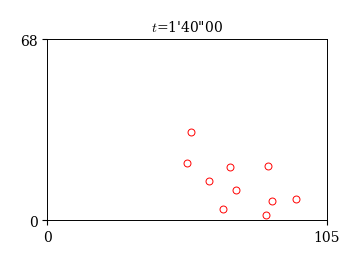

In [24]:
fig, ax = plt.subplots()

# フレーム番号
i=2000

# 位置の描画
x, y = X.loc[i], Y.loc[i]
ax.plot(x, y, 'ro', ms=5, mfc='None')

# 時刻の表示
t = i*0.05
m, s = np.floor(t/60.).astype(int), np.floor(t % 60).astype(int)
ss = ("%.2f" % (t % 60 - s)).replace('.', '')[1:].zfill(2)
ax.set_title('$t$=%s\'%s\"%s' % (m, s, ss), fontsize=10)

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105])
ax.set_yticks([0, 68])
ax.set_aspect('equal')

### 重心と標準偏差の計算

集団の動きを解析する際に，チーム全体のおおまかな位置と広がりを把握することは非常に重要である．
これらの量の定義の仕方は色々と考えられるが，以下では重心と慣性半径を計算する．

**チームの重心**

チームの重心は，メンバー全員の平均位置を表す量で，以下のように定義される：

$$
X_{c}(i) = \frac{1}{N} \sum_{u=1}^{N} X_{u}(i), \\[10pt]
Y_{c}(i) = \frac{1}{N} \sum_{u=1}^{N} Y_{u}(i), \\[10pt]
$$

ここで，$X_{u}(i),\ Y_{u}(i)$は第$i$フレームの選手$u$の$x,\ y$座標である．
これは，全選手の$x,\ y$座標の平均値を求めれば良いので，以下のように計算できる：

In [25]:
Xc = X.mean(axis=1)
Yc = Y.mean(axis=1)
Xc.head()

0    36.250
1    36.260
2    36.272
3    36.285
4    36.297
dtype: float64

**チームの広がり**

次に，チームの重心からの広がりを表す量を導入する．
定義は色々と考えられるが，ここでは以下の量を用いる．

$$
    R(i) = \sqrt{ \frac{1}{N} \sum_{u=1}^{N} [(X_{u}(i) - X_{c}(i))^{2} + (Y_{u}(i) - Y_{c}(i))^{2}] }
$$

これは，$ x $ 方向の分散と $ y $ 方向の分散の和の平方根である．

In [26]:
R = np.sqrt(X.var(ddof=0, axis=1) + Y.var(ddof=0, axis=1))
R.head()

0    14.796
1    14.789
2    14.782
3    14.776
4    14.771
dtype: float64

**重心と慣性半径の描画**

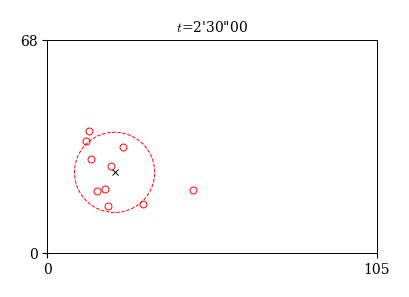

In [28]:
fig, ax = plt.subplots(figsize=(4, 4))

# フレーム番号
i=3000

# 位置の描画
x, y = X.loc[i], Y.loc[i]
ax.plot(x, y, 'ro', ms=5, mfc='None')

# 重心と標準偏差の描画
xc, yc = Xc.loc[i], Yc.loc[i]
r = R.loc[i]
ax.plot(xc, yc, 'kx')
theta = np.linspace(0, 2*np.pi)
ax.plot(xc + r*np.cos(theta), yc + r*np.sin(theta), 'r--')

# 時刻の表示
t = i*0.05
m, s = np.floor(t/60.).astype(int), np.floor(t % 60).astype(int)
ss = ("%.2f" % (t % 60 - s)).replace('.', '')[1:].zfill(2)
ax.set_title('$t$=%s\'%s\"%s' % (m, s, ss), fontsize=10)

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105])
ax.set_yticks([0, 68])
ax.set_aspect('equal')

### 速度の計算

次に，位置座標から速度を求めてみよう．
フレーム $ i $ における速度の $ x, y $ 成分を $ V_{x}(i),\ V_{y}(i) $ とすると，これらは以下のように計算される：

$$
    V_{x}(i) = \frac{X(i) - X(i-n)}{0.05n},\\[10pt]
    V_{y}(i) = \frac{Y(i) - Y(i-n)}{0.05n}
$$

ここで，$ X(i),\ Y(i) $ は 第 $i$ フレームの $x, y$ 座標を表し，$n$ はフレームの増分である．
また，1フレームが0.05秒なので， $ 0.05n $ は $ n $ フレームの経過時間である．
これより， $ V_{x}(i),\ V_{y}(i) $ の単位は m/s となる．

以下では，$ n=20 $とし，20フレーム（=1秒間）の平均速度と求める．
実装には`diff`メソッドを用いて`n`フレーム前との差分を計算すれば良い．

In [29]:
n = 20
Vx, Vy = X.diff(n)/(0.05*n), Y.diff(n)/(0.05*n)  # nフレーム（0.05n秒）前との差を取る

In [30]:
Vx.tail()

,1,2,5,7,8,9,10,13,14,15
56656,NaN,-0.370,0.564,0.531,1.639,-1.013,-0.978,0.130,0.270,0.263
56657,NaN,-0.431,0.571,0.529,1.623,-0.973,-0.900,0.174,0.265,0.248
56658,NaN,-0.472,0.572,0.524,1.597,-0.929,-0.817,0.222,0.259,0.229
56659,NaN,-0.494,0.566,0.517,1.564,-0.881,-0.731,0.273,0.252,0.206
56660,NaN,-0.496,0.555,0.509,1.523,-0.831,-0.643,0.326,0.244,0.179


**秩序変数**

やや高度ではあるが，以下で定義される秩序変数（Order Parameter）という量を計算してみよう：

$$
\phi(i) = \left| \frac{1}{N} \sum_{u=1}^{N} \frac{\vec{v}_{u}(i)}{|\vec{v}_{u}(i)|} \right|
$$

秩序変数は，集団の向きの揃い具合を表す量で，統計物理学の分野でよく用いられる．
その定義域は$0\le\phi(t)\le 1$であり，0に近いほど集団の移動方向がバラバラ，1に近いほど揃っていることを意味する．
定義より，秩序変数は速度ベクトルから以下のように計算することができる．

In [42]:
V = np.sqrt(Vx**2 + Vy**2)
OP = np.sqrt(np.sum(Vx/V, axis=1)**2 + np.sum(Vy/V, axis=1)**2) / 10

In [45]:
OP.iloc[2500]

0.942

**速度ベクトルの描画**

速度が計算できたので，これらを描画してみよう．
速度ベクトルの描画には，matplotlibの`quiver`関数を用いて選手の位置を始点とする矢印を描けば良い．
また，秩序変数は時刻の横に文字列として出力する．
フレーム番号を変えると，矢印の向きの揃い具合と連動して秩序変数の値が変化することが分かる．

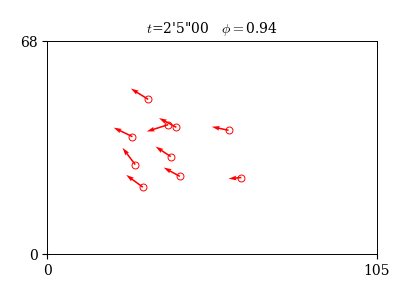

In [44]:
fig, ax = plt.subplots(figsize=(4,4))

# フレーム番号
i=2500

# 位置の描画
x, y = X.loc[i], Y.loc[i]
ax.plot(x, y, 'ro', ms=5, mfc='None')

# 速度ベクトルの描画
vx, vy = Vx.loc[i], Vy.loc[i]
ax.quiver(x, y, vx, vy, color='r', angles='uv', units='xy', scale=0.7, width=0.5)

# 時刻と秩序変数の表示
op = np.round(OP.loc[i], 2)
t = i*0.05
m, s = np.floor(t/60.).astype(int), np.floor(t % 60).astype(int)
ss = ("%.2f" % (t % 60 - s)).replace('.', '')[1:].zfill(2)
ax.set_title('$t$=%s\'%s\"%s   $\phi=$%s' % (m, s, ss, op), fontsize=10)

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105])
ax.set_yticks([0, 68])
ax.set_aspect('equal')

### 発展問題

- 重心の $ x $ 座標と標準偏差の関係を可視化し，結果を考察せよ．
- 速度から速さ（速度の大きさ）を求め，選手ごとに速さのヒストグラムを求めよ．
- 加速度を計算せよ
  - ヒント：速度の変化率が加速度である．
- 各選手の走行距離を計算せよ
  - ヒント：細かい時間間隔での移動距離を全て足し合わせれば良い．
- 各選手のスプリント回数を計算せよ
  - ヒント：Jリーグでは，時速25km以上で1秒以上走った回数をスプリント回数と定義している．

### フォーメーション

サッカーにおいてフォーメーションが重要な概念であることは言うまでもない．
しかし，「フォーメーションとは何か？」と問われると，明確に答えることは意外と難しい．
おおよそ，「チーム内の選手の決まった配置」とか「選手同士の相対的位置関係のパターン」というのがフォーメーションに対する漠然としたイメージだろう．

では，こうしたフォーメーションを定量化・可視化するにはどうすればよいだろうか？
実は，これには次の２つの方法がある：
1. ある時間幅における選手の平均的な位置から割り出す
    - 3-4-3, 4-4-2などの数字の組を用いる
2. 特定の時刻における選手の隣接関係から定める
    - ドロネーネットワークを用いる
    
以下では，トラッキングデータを用いて，1の方法を簡単に解説する．
2については付録を参照してほしい．

**絶対座標系**

まずは何も考えずに試合前半の全選手の位置をフィールド上に色分けしてプロットしてみよう．
この場合，座標原点がフィールドの左下に常に固定されているので，**絶対座標系**と呼ばれる．

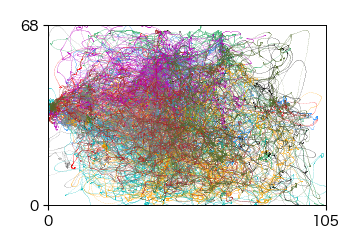

In [27]:
fig, ax = plt.subplots(figsize=(3.5, 3))

for u in X.columns:
    ax.plot(X[u], Y[u], '.', ms=0.05)
    
ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105])
ax.set_yticks([0, 68])
ax.set_aspect('equal')

プロットの結果を見て明らかなように，各選手はフィールド上を縦横無尽に動き周っていることがわかる．
ポジションごとにおおよそ右サイドや中盤などの区分けはできるかもしれないが，この結果からチームのフォーメーションを推定することはできない．

**重心座標系**

次に，絶対座標系でのプロットは止めて，チームの重心を原点とする座標系に変換してみよう．
これを**重心座標系**と呼ぶ．
各選手の座標を重心座標系に変換するには，以下のように各時刻において選手の座標から重心の座標を引き算すればよい．

In [28]:
Xc = X.sub(X.mean(axis=1), axis=0)
Yc = Y.sub(Y.mean(axis=1), axis=0)

以下の２つのグラフは，いずれも重心座標系において全選手の位置を色分けしてプロットした結果である．
１つ目は選手ごとに各時刻の位置をマーカーでプロットしており，2つ目は選手ごとに平均位置と標準偏差（慣性半径）をプロットしている．

Text(0, 0.5, '$Y$')

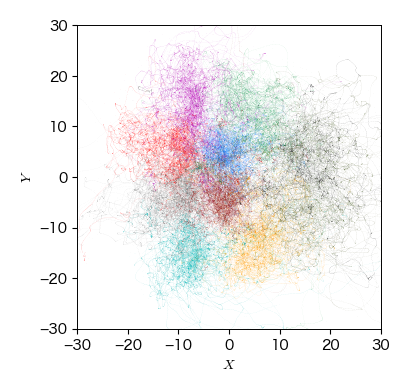

In [29]:
fig, ax = plt.subplots(figsize=(4, 4))

for u in X.columns:
    ax.plot(Xc[u], Yc[u], '.', ms=0.01)
    
ax.set_xlim(-30, 30); ax.set_ylim(-30, 30)
ax.set_aspect('equal')
ax.set_xlabel('$X$'); ax.set_ylabel('$Y$')

Text(0, 0.5, '$Y$')

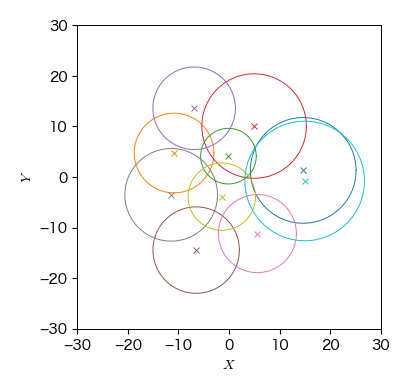

In [30]:
fig, ax = plt.subplots(figsize=(4, 4))

cmap = plt.get_cmap("tab10") # カラーマップ
for i, u in enumerate(X.columns):
    # 平均位置
    ax.plot(Xc[u].mean(), Yc[u].mean(), 'x', ms=5, color=cmap(i))
    
    # 標準偏差（慣性半径）
    r = np.sqrt(Xc[u].var() + Yc[u].var())
    theta=np.linspace(0, 2*np.pi)
    ax.plot(Xc[u].mean()+r*np.cos(theta), Yc[u].mean()+r*np.sin(theta), '-', color=cmap(i))
    
ax.set_xlim(-30, 30); ax.set_ylim(-30, 30)
ax.set_aspect('equal')
ax.set_xlabel('$X$'); ax.set_ylabel('$Y$')

今度は選手ごとにだいたい決まった定位置（☓）を持ち，そこから標準偏差くらいの広がり（◯）を持って移動している様子が見て取れる．
特に，守備側から４人，４人，２人という並びになっており，おおよそ4-4-2というフォーメーションが見事に可視化されている．

## アニメーション

最後にトラッキングデータの解析の仕上げとして，アニメーションの作成方法を紹介する．
アニメーションはMatplotlibの`FuncAnimation`を用いると簡単に実装できる．
まずは`FuncAnimation`を以下のようにインポートしておく：

In [1]:
from matplotlib.animation import FuncAnimation

アニメーションの表示には少々注意が必要である．
これまで，MatplotlibによるグラフはJupyter Lab内に表示することができた．
これは，デフォルトの設定としてグラフの出力先がJupyter Lab内となっていたからであり，明示的に設定するには以下のコマンドを実行する：

In [32]:
%matplotlib inline

一方，アニメーションを表示するには上の設定を以下のように変更する必要がある：

In [ ]:
%matplotlib tk

この設定に変更しておくと，MatplotlibのグラフはJupyter Lab内ではなく別ウインドウとして表示されるはずである．
この辺りの詳細については「5. Matplotlibの基礎」の「5.6.1. 描画結果の出力先」にまとめてある．

### 位置

In [5]:
X = pd.read_csv('./x_1st.csv', encoding='utf-8', index_col=0)
Y = pd.read_csv('./y_1st.csv', encoding='utf-8', index_col=0)

In [12]:
# 描画関数
def update(i):
    #　位置座標の更新
    x, y = X.loc[int(i)], Y.loc[int(i)]
    pt.set_data(x, y)

    return [pt]

# グラフの設定
fig, ax = plt.subplots(figsize=(5, 5))
pt, = ax.plot([], [], 'bo', ms=5, mfc='None')

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105]); ax.set_yticks([0, 68])
ax.set_aspect('equal')

# 実行
anim = FuncAnimation(fig, update, blit=True, interval=10)

/var/folders/15/9xbz42sj4_ncrjjdpr251pr00000gn/T/ipykernel_15747/4000753284.py:18: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = FuncAnimation(fig, update, blit=True, interval=10)


### 位置とテキスト

In [11]:
# 描画関数
def update(i):
    #　位置座標の更新
    x, y = X.loc[int(i)], Y.loc[int(i)]
    pt.set_data(x, y)
    
    t = i*0.05
    m, s = np.floor(t/60.).astype(int), np.floor(t % 60).astype(int)
    ss = ("%.2f" % (t % 60 - s)).replace('.', '')[1:].zfill(2)
    title.set_text('$t$=%s\'%s\"%s' % (m, s, ss))

    return list(np.hstack([pt, title]))

# グラフの設定
fig, ax = plt.subplots(figsize=(5, 5))
pt, = ax.plot([], [], 'bo', ms=5, mfc='None')
title = ax.text(80, 63, '', fontsize=10)

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105]); ax.set_yticks([0, 68])
ax.set_aspect('equal')

# 実行
anim = FuncAnimation(fig, update, blit=True, interval=10)

/var/folders/15/9xbz42sj4_ncrjjdpr251pr00000gn/T/ipykernel_15747/1276168880.py:24: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = FuncAnimation(fig, update, blit=True, interval=10)


invalid command name "13150634688_on_timer"
    while executing
"13150634688_on_timer"
    ("after" script)


### 位置・速度ベクトル・テキスト

In [8]:
# 速度ベクトルと秩序変数の計算
Vx, Vy = X.diff(20), Y.diff(20)
V = np.sqrt(Vx**2 + Vy**2)

In [10]:
# 描画関数
def update(i):
    # 位置の更新
    x, y = X.loc[int(i)], Y.loc[int(i)]
    pt.set_data(x, y)
    
    # 速度ベクトルの更新
    vx, vy = Vx.loc[int(i)], Vy.loc[int(i)]
    aw.set_offsets(np.c_[x, y])
    aw.set_UVC(vx, vy)
    
    # テキスト
    t = i*0.05
    m, s = np.floor(t/60.).astype(int), np.floor(t % 60).astype(int)
    ss = ("%.2f" % (t % 60 - s)).replace('.', '')[1:].zfill(2)
    text.set_text('$t$=%s\'%s\"%s' % (m, s, ss))

    return list(np.hstack([pt, aw, text]))

# グラフの設定
fig, ax = plt.subplots(figsize=(5, 5))
pt, = ax.plot([], [], 'bo', ms=5, mfc='None')
aw = ax.quiver(np.zeros(10), np.zeros(10), np.zeros(10), np.zeros(10),\
               color='b', angles='uv', units='xy', scale=0.7, width=0.5)
text = ax.text(65, 63, '', fontsize=10)

ax.set_xlim(0, 105); ax.set_ylim(0, 68)
ax.set_xticks([0, 105]); ax.set_yticks([0, 68])
ax.set_aspect('equal')

# 実行
anim = FuncAnimation(fig, update, blit=True, interval=20)

/var/folders/15/9xbz42sj4_ncrjjdpr251pr00000gn/T/ipykernel_15747/3801862582.py:32: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = FuncAnimation(fig, update, blit=True, interval=20)


invalid command name "13289213120_on_timer"
    while executing
"13289213120_on_timer"
    ("after" script)
